In [ ]:
import pandas as pd

In [ ]:
import numpy as np

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn

In [ ]:
import os

In [ ]:
os.getcwd()

In [ ]:
df = pd.read_csv('netflix.csv')

In [ ]:
closed_prices = df["Close"]

In [53]:
print(df.head())

         Date      High       Low      Open     Close     Volume  Adj Close
0  23-05-2002  1.242857  1.145714  1.156429  1.196429  104790000   1.196429
1  24-05-2002  1.225000  1.197143  1.214286  1.210000   11104800   1.210000
2  28-05-2002  1.232143  1.157143  1.213571  1.157143    6609400   1.157143
3  29-05-2002  1.164286  1.085714  1.164286  1.103571    6757800   1.103571
4  30-05-2002  1.107857  1.071429  1.107857  1.071429   10154200   1.071429


In [52]:
print(closed_prices)

0         1.196429
1         1.210000
2         1.157143
3         1.103571
4         1.071429
           ...    
4876    634.809998
4877    639.099976
4878    631.849976
4879    632.659973
4880    627.039978
Name: Close, Length: 4881, dtype: float64


In [54]:
seq_len = 15

In [55]:
mm=MinMaxScaler()
scaled_price = mm.fit_transform(np.array(closed_prices)[... , None]).squeeze()

In [56]:
print(scaled_price)

[0.0012894  0.00131064 0.00122789 ... 0.9886493  0.98991744 0.9811187 ]


In [57]:
X = []
y = []

In [58]:
for i in range(len(scaled_price) - seq_len):
    X.append(scaled_price[i : i + seq_len])
    y.append(scaled_price[i + seq_len])

In [59]:
print(len(X))

4866


In [60]:
print(X[0])

[0.0012894  0.00131064 0.00122789 0.00114402 0.00109369 0.00110152
 0.00118316 0.00116638 0.00121223 0.00126703 0.0011675  0.00122677
 0.0012223  0.00112724 0.00111159]


In [61]:
X = np.array(X)[... , None]
y = np.array(y)[... , None]

In [62]:
train_x = torch.from_numpy(X[:int(0.8 * X.shape[0])]).float()
train_y = torch.from_numpy(y[:int(0.8 * X.shape[0])]).float()
test_x = torch.from_numpy(X[int(0.8 * X.shape[0]):]).float()
test_y = torch.from_numpy(y[int(0.8 * X.shape[0]):]).float()

In [63]:
print(train_x.shape,test_x.shape)

torch.Size([3892, 15, 1]) torch.Size([974, 15, 1])


In [64]:
class Model(nn.Module):
    def __init__(self , input_size , hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size , hidden_size , batch_first = True)
        self.fc = nn.Linear(hidden_size , 1)
    def forward(self , x):
        output , (hidden , cell) = self.lstm(x)
        return self.fc(hidden[-1 , :])
model = Model(1 , 64)

In [65]:
optimizer = torch.optim.Adam(model.parameters() , lr = 0.001)
loss_fn = nn.MSELoss()

In [66]:
num_epochs = 100

In [67]:
for epoch in range(num_epochs):
    output = model(train_x)
    loss = loss_fn(output , train_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0 and epoch != 0:
        print(epoch , "epoch loss" , loss.detach().numpy())

10 epoch loss 0.004530976
20 epoch loss 0.0033866097
30 epoch loss 0.00062964077
40 epoch loss 0.00023849781
50 epoch loss 0.00014930166
60 epoch loss 2.7405733e-05
70 epoch loss 3.449415e-05
80 epoch loss 2.5732272e-05
90 epoch loss 2.1957028e-05


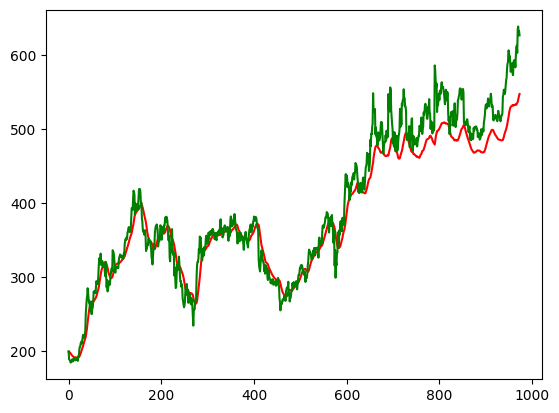

In [69]:
model.eval()
with torch.no_grad():
    output = model(test_x)

pred = mm.inverse_transform(output.numpy())
real = mm.inverse_transform(test_y.numpy())

plt.plot(pred.squeeze() , color = "red" , label = "predicted")
plt.plot(real.squeeze() , color = "green" , label = "real")
plt.show()